In [1]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import torch
from tqdm import tqdm 
from torch import nn
from torch.optim import Adam
from scipy.special import gammaln

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from numpy.lib.stride_tricks import sliding_window_view
from models.last_layer_models import LLI, train_last_layer_det, LastLayerVIClosedForm
from utils.data_utils import create_synthetic_train_data


np.random.seed(100)

# VI with a Gausian var. distribution \& closed form ELBO

We want to approximate the posterior of the following model
\begin{align}
y = w^T \psi(x) + \varepsilon, \qquad \varepsilon \sim \mathcal{N}(0, \sigma_{\varepsilon}^2), \qquad w \sim \mathcal{N}(0, \tau^2I)
\end{align}
where we assume $\sigma_{\varepsilon}$ and $\tau^2$ to be fixed and known. We have a standard normal prior on the last-layer weights.
In this case we can write the ELBO in closed-form as 

\begin{align*}
        \text{ELBO}(\lambda) = \textcolor{purple}{E_{q_(\lambda)}[\log p(y \mid x, w)]} - \textcolor{green}{KL( q_{\lambda}(w) || p(w))} = \textcolor{purple}{\log \phi_1(y ; \mu_{w}^T \psi , \sigma_{\varepsilon}^2) - \frac{1}{2}\sigma_{\varepsilon}^{-2} \psi^T \Sigma_w \psi}  - \textcolor{green}{KL( q_{\lambda}(w) || p(w))},
\end{align*}

where $\textcolor{purple}{q_{\lambda}(w) = \phi_1(w; \mu_w, \Sigma_w)}$. We have a variational distribution with a full covariance matrix.\
For new observations we can obtain the predictive posterior distribution conditional on the parameters $\mu_w, \tau^2$
\begin{align}
p(y | x, \mu_w, \tau^2) = \mathcal{N}(\mu_w^T\psi, \psi^T \Sigma_w \psi + \sigma_{\varepsilon}^2I).
\end{align}

## 1. Data
First, we set up a synthetic dataset using a noisy sine function, where $y = \sin(x) + \varepsilon$ where $\varepsilon \sim \mathcal{N}(0, \sigma_{\varepsilon}^2)$.

In [2]:
sigma_eps = 0.3
xs, ys, xs_train, ys_train, xs_val, ys_val = create_synthetic_train_data(xs_range = [-4,4], num_points = 200,  sigma_eps = sigma_eps)
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

## 2. Model
We use a dense, feedforward neural network with ReLU activations in all but the output layer.

In [3]:
# all models have 4 layers with 100, 100, 5 and 1 neuron(s), respectively.
model_dims = [1, 100, 100, 100, 10, 1]
num_epochs = 100

# initialize model
lli_net = LLI(model_dims)
    
# train model
model, losses_train, losses_val = train_last_layer_det(model = lli_net, dataloader_train = dataloader_train,
                     dataloader_val= dataloader_train, weight_decay = 0, num_epochs = 100)

# freeze weights after training
for param in lli_net.parameters():
    param.requires_grad = False

# get last-layer embeddings psi
with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)

100%|██████████| 100/100 [00:00<00:00, 150.23it/s]


## 3. Run VI with closed-form ELBO
We now run VI with the closed-form ELBO objective from above. Because the objective is available in closed-form, we don't have to draw samples from $q_{\lambda}$.
In each VI iteration, we
1. Compute $\hat{y}$ based on the current variational parameters
2. Compute the exp. log-likelihood $\textcolor{purple}{E_{q_(\lambda)}[\log p(y \mid x, w)]}$ and KL term $\textcolor{green}{KL( q_{\lambda}(w) || p(w))}$ for the ELBO.
3. Update the variational parameters to maximize the ELBO $\lambda^{[t + 1]} = \lambda^{[t]} - \nabla_{\lambda}\text{ELBO}(\lambda)$.

We set the prior variance for $w$ as $\tau^2 = 1$ and the variance for the observational noise to the true value $\sigma_{\varepsilon} = 0.3$.

In [4]:

last_layer_vi = LastLayerVIClosedForm(dim_last_layer=Psi.shape[1], dim_output=1)
optimizer_vi = Adam(last_layer_vi.parameters(), lr=1e-2)
num_epochs = 10000
sigma_eps_sq = sigma_eps**2

elbos = []
for epoch in range(num_epochs):
    optimizer_vi.zero_grad()
    
    # compute y_hat with current var. parameters
    pred_y_mu= last_layer_vi.forward_det(Psi)
    
    # get current covariance of var. distribution
    L = last_layer_vi.get_L().squeeze() # Cholesky factor
    Sigma_w = L @ L.T # actual covariance matrix

    # get kl term
    kl = last_layer_vi.kl_divergence()

    # get likelihood term
    log_likelihood = (-0.5 * Psi.shape[0] * torch.log(2 * torch.pi * torch.tensor(sigma_eps_sq)) \
        - 0.5  * torch.sum((ys_train - pred_y_mu) ** 2 / sigma_eps_sq) \
            - 0.5 *( torch.diagonal(Psi @ Sigma_w @ Psi.T).sum())/ sigma_eps_sq)
    
    # combine for final ELBO
    elbo = (
        log_likelihood
        - kl
    )
    loss = -elbo
    loss.backward()
    optimizer_vi.step()
    if epoch % 100 == 0:
        print(f"VI epoch {epoch} ELBO: {elbo.item():.3f} \n 'log likelihood: {log_likelihood.item():.3f}")

    elbos.append(elbo.item())

VI epoch 0 ELBO: -3535.051 
 'log likelihood: -3534.381
VI epoch 100 ELBO: -518.158 
 'log likelihood: -517.321
VI epoch 200 ELBO: -238.530 
 'log likelihood: -236.653
VI epoch 300 ELBO: -149.520 
 'log likelihood: -146.747
VI epoch 400 ELBO: -108.995 
 'log likelihood: -105.526
VI epoch 500 ELBO: -86.907 
 'log likelihood: -82.893
VI epoch 600 ELBO: -73.446 
 'log likelihood: -68.985
VI epoch 700 ELBO: -64.477 
 'log likelihood: -59.634
VI epoch 800 ELBO: -58.112 
 'log likelihood: -52.930
VI epoch 900 ELBO: -53.341 
 'log likelihood: -47.852
VI epoch 1000 ELBO: -49.697 
 'log likelihood: -43.923
VI epoch 1100 ELBO: -46.839 
 'log likelihood: -40.802
VI epoch 1200 ELBO: -44.565 
 'log likelihood: -38.279
VI epoch 1300 ELBO: -42.731 
 'log likelihood: -36.213
VI epoch 1400 ELBO: -41.239 
 'log likelihood: -34.501
VI epoch 1500 ELBO: -40.015 
 'log likelihood: -33.068
VI epoch 1600 ELBO: -39.021 
 'log likelihood: -31.878
VI epoch 1700 ELBO: -38.162 
 'log likelihood: -30.835
VI epoch 1

Text(0, 0.5, 'ELBO')

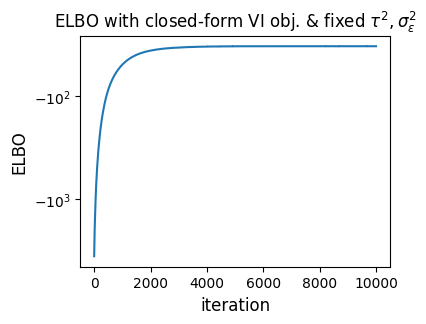

In [5]:
fig, axs = plt.subplots(1,1, figsize = (4,3))
axs.plot(elbos)
axs.set_yscale('symlog')
axs.set_title(r'ELBO with closed-form VI obj. & fixed $\tau^2, \sigma_{\varepsilon}^2$')
axs.set_xlabel('iteration', size = 12)
axs.set_ylabel('ELBO', size = 12)

## 4. Predictions
Compute the predictive mean and standard deviation using
\begin{align}
p(y | x, \mu_w, \tau^2) = \mathcal{N}(\mu_w^T\psi, \psi^T \Sigma_w \psi + \sigma_{\varepsilon}^2I).
\end{align}

In [6]:
X_test = torch.linspace(-10,10, 300).unsqueeze(1)
Psi_test = lli_net.get_ll_embedd(X_test)
pred_mean = (Psi_test @  last_layer_vi.mu.T).detach().numpy().squeeze()
L  = last_layer_vi.get_L()
Z = Psi_test @ L.squeeze()  
pred_std = torch.sqrt((Z ** 2).sum(dim=1) + sigma_eps_sq).detach().numpy()

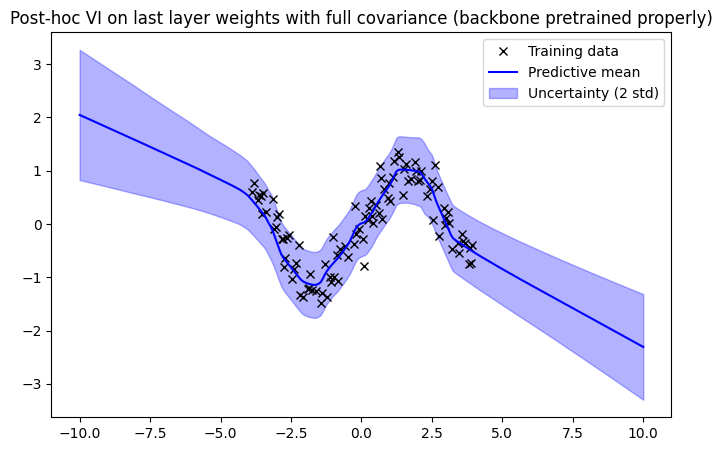

In [7]:
plt.figure(figsize=(8,5))
#plt.ylim(-2,2)
plt.plot(xs_train.numpy(), ys_train.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), pred_mean, 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 pred_mean - 2 * pred_std,
                pred_mean + 2 * pred_std,
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with full covariance (backbone pretrained properly)")
plt.show()

# Ridge

We now want to perform the same estimation, but with a more sophisticated model: a hierarchical model with a ridge prior.
We now equip both $\tau^2$ and $\sigma_{\varepsilon}^2$ with inverse-gamma priors. 
Before, we merely guessed their values - or "cheated" a bit because we used the true value of $\sigma_{\varepsilon}^2$.
Equipping both variances with priors protects us from severe misspecification of these values.

We now have
\begin{align}
\tau^2 \sim  \mathcal{IG}(a_\tau, b_{\tau}) \qquad \sigma_{\varepsilon}^2 \sim \mathcal{IG}(a_\sigma, b_{\sigma}),
\end{align}
where $a_\tau > 0 $ ($a_\sigma$) is the shape and $b_{\tau} > 0$ ($b_{\sigma}$) is the scale. To get an "uninformative" prior, we can set $a = 2, b=2$.
It's obvious, that our misspeficiation now merely moved one layre up in the hierarchy. We could of course still very much choose "bad" values of $a,b$. But these will have a smaller influence then directly misspecifying $\tau^2, \sigma_{\varepsilon}^2$.

Our variational distribution now has two additional parameters: $\log(\tau^2), \log(\sigma_{\varepsilon}^2)$. We need to reparameterize them with logarithms because the normal distribution can take on pos. and neg. values - but the variances are only positive.

Our ELBO now looks a bit different then before. We still have the expected log-likelihood but several KL terms for our different priors:
\begin{align}
\text{ELBO}(\lambda) = \textcolor{purple}{E_{q_\lambda}[\log p(y \mid x, w, \tau^2, \sigma_{\varepsilon}^2)]} - \textcolor{green}{\mathbb{E}_{q_\lambda}[KL(q_{\lambda}(w) || p(w | \tau^2))]} - \textcolor{red}{KL( q_{\lambda}(\tau^2) || p(\tau^2))} - \textcolor{blue}{KL( q_{\lambda}(\sigma_{\varepsilon}^2) || p(\sigma_{\varepsilon}^2))}
\end{align}
We now only use a diagonal covariance matrix in the variational density $q$.

Let's again set up our LastLayerVI class.

In [4]:
for param in lli_net.parameters():
    param.requires_grad = False

with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)


class LastLayerVI(nn.Module):
    def __init__(self, in_features, out_features, prior_var=.3):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.log_tau_sq = nn.Parameter(torch.ones(out_features, 1))
        self.log_sigma_eps_sq = nn.Parameter(torch.ones(out_features, 1))

        self.Sigma_q_unconstrained = nn.Parameter(torch.randn(out_features, in_features + 2) * 0.01)
    
    def get_tau_sq(self):
        return torch.nn.functional.exp(self.log_tau_sq)
    
    def get_sigma_eps_sq(self):
        return torch.nn.functional.exp(self.log_sigma_eps_sq)

    def get_Sigma_q(self):
        Sigma_q = torch.nn.functional.softplus(self.Sigma_q_unconstrained) + 1e-5
        return Sigma_q
    
    def forward(self, X, S = 5):
        # sample 
        params = torch.cat([self.mu, self.log_tau_sq, self.log_sigma_eps_sq], dim = -1 )
        eps = torch.randn(S, params.shape[1])  
        Sigma_q = self.get_Sigma_q()
        params_samples = params + L*eps

        y_sample = X @ params_samples[:, :self.in_features].t()
        
        return params_samples, params, y_sample, Sigma_q
    
    def forward_sample(self, X, S = 1):
        # sample 
        params = torch.cat([self.mu, self.log_tau_sq, self.log_sigma_eps_sq], dim = -1 )
        eps = torch.randn(S, params.shape[1])  
        L = self.get_Sigma_q()
        params_samples = params + L*eps
        w_sample = params_samples[:, :self.in_features]

        y_sample = X @ w_sample.T # variance is missing here
        
        return y_sample

In [30]:
last_layer_vi = LastLayerVI(in_features=Psi.shape[1], out_features=1)
optimizer_vi = Adam(last_layer_vi.parameters(), lr=1e-3)
num_epochs = 30000
sigma_eps_sq = sigma_eps**2
N, L = Psi.shape

In [31]:
def kl_w_vectorized(mu, Sigma_q, tau_sq_samples):
    _, L = mu.shape

    logdet_Sigma = torch.sum(torch.log(Sigma_q), dim=1)
    trace_term = torch.sum(Sigma_q, dim=1)              
    mu_norm_sq = torch.sum(mu**2, dim=1)                
    log_tau_sq = torch.log(tau_sq_samples)               

    kl = 0.5 * (trace_term / tau_sq_samples + mu_norm_sq / tau_sq_samples - L + L * log_tau_sq - logdet_Sigma)

    return kl.mean()

In [32]:
def kl_tau_sq(q_log_pdf_normal_value, tau_sq_samples, a_tau, b_tau):
    log_prior_ig = (
        a_tau * torch.log(torch.tensor(b_tau)) 
        - torch.lgamma(torch.tensor(a_tau))
        - (a_tau + 1) * torch.log(tau_sq_samples) 
        - b_tau / tau_sq_samples
    )
    
    kl = q_log_pdf_normal_value.mean() - log_prior_ig.mean()
    return kl

In [33]:
def q_log_pdf_lognormal(sigma_eps_sq_samples, mu_log, log_var_log):

    var_log = torch.exp(log_var_log)
    log_x = torch.log(sigma_eps_sq_samples)
    log_pdf = (
        - log_x
        - 0.5 * torch.log(2 * torch.pi * var_log)
        - (log_x - mu_log)**2 / (2 * var_log)
    )
    return log_pdf

def log_p_sigma_eps_sq_ig(sigma_eps_sq, a_sigma, b_sigma):
    log_prob1 = a_sigma * math.log(b_sigma) - gammaln(a_sigma)
    log_prob2 = -(a_sigma + 1) * torch.log(sigma_eps_sq) - b_sigma / sigma_eps_sq
    return log_prob1 + log_prob2  # shape [S]

def kl_sigma_eps_sq(q_log_pdf, sigma_eps_sq_samples, a_sigma, b_sigma):
    log_prior = log_p_sigma_eps_sq_ig(sigma_eps_sq_samples, a_sigma, b_sigma)
    return (q_log_pdf - log_prior).mean()

In [34]:
elbos = []
for epoch in range(num_epochs):
    optimizer_vi.zero_grad()
    
    params_samples, params, y_sample, Sigma_q = last_layer_vi.forward(Psi)

    # samples of parameters
    w_samples =  params_samples[:, :last_layer_vi.in_features]
    sigma_eps_sq_samples = torch.exp(params_samples[:, -1]) + 1e-5
    tau_sq_samples = torch.exp(params_samples[:, -2]) + 1e-5

    # variational means
    q_w_mu = params[:, :last_layer_vi.in_features]
    q_log_tau_sq_mu = params_samples[:, -2]
    q_log_sigma_eps_sq_mu = params_samples[:, -1]

    q_log_sigma_eps_sq_var = Sigma_q[:, -1]
    q_log_tau_sq_var = Sigma_q[:, -2]

    # likelihood
    log_likelihood = (
        - 0.5 * N * torch.log(sigma_eps_sq_samples) 
        - 0.5 * (torch.sum((ys_train - y_sample) ** 2)/ sigma_eps_sq_samples))
    
    # expected KL
    kl_w = kl_w_vectorized(w_samples, Sigma_q[:,:last_layer_vi.in_features], tau_sq_samples)
    q_log_pdf_normal_value_eps = q_log_pdf_lognormal(sigma_eps_sq_samples, q_log_sigma_eps_sq_mu, q_log_sigma_eps_sq_var)
    
    kl_sigma_eps_sq_value = kl_sigma_eps_sq(q_log_pdf_normal_value_eps, sigma_eps_sq_samples, 2, 2)
    q_log_pdf_normal_value_tau_value = q_log_pdf_lognormal(tau_sq_samples, q_log_tau_sq_mu, q_log_tau_sq_var)
    kl_tau_sq_value = kl_tau_sq(q_log_pdf_normal_value_tau_value, tau_sq_samples, 2, 2)
    
    elbo = (
        log_likelihood.mean() 
        - kl_w - kl_sigma_eps_sq_value - kl_tau_sq_value
    )
    loss = -elbo
    loss.backward()
    optimizer_vi.step()
    if epoch % 1000 == 0:
        print(f"VI epoch {epoch} ELBO: {elbo.item():.3f}")

    elbos.append(elbo.item())

VI epoch 0 ELBO: -70266808.000
VI epoch 1000 ELBO: -73340.633
VI epoch 2000 ELBO: -777678272.000
VI epoch 3000 ELBO: -3449718272.000
VI epoch 4000 ELBO: -58434176.000
VI epoch 5000 ELBO: -2200727.750
VI epoch 6000 ELBO: -432204544.000
VI epoch 7000 ELBO: -9701723.000
VI epoch 8000 ELBO: -7142255.000
VI epoch 9000 ELBO: -23825504.000
VI epoch 10000 ELBO: -10273519.000
VI epoch 11000 ELBO: -7831.880
VI epoch 12000 ELBO: -4102082560.000
VI epoch 13000 ELBO: -5240779776.000
VI epoch 14000 ELBO: -96518.266
VI epoch 15000 ELBO: -1163465.625
VI epoch 16000 ELBO: -6707325.500
VI epoch 17000 ELBO: -7409.767
VI epoch 18000 ELBO: -46551.844
VI epoch 19000 ELBO: -12928077.000
VI epoch 20000 ELBO: -15083456.000
VI epoch 21000 ELBO: -202829.391
VI epoch 22000 ELBO: -496474.781
VI epoch 23000 ELBO: -7472.854
VI epoch 24000 ELBO: -26502.207
VI epoch 25000 ELBO: -20362.652
VI epoch 26000 ELBO: -113647.094
VI epoch 27000 ELBO: -242703.859
VI epoch 28000 ELBO: -980795072.000
VI epoch 29000 ELBO: -1846.42

We are now numerically estimating $\mathbb{E}_{q_{\lambda}}$, so our ELBO looks a bit more noisy.

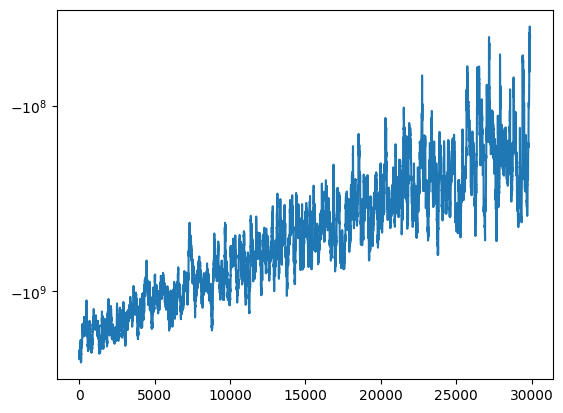

In [35]:
plt.plot(sliding_window_view(elbos, 100).mean(axis=1))
plt.yscale('symlog')

We also cannot express the pred. posterior in closed-form anymore (it is not Gaussian).
Instead we can need to sample from the var. distribution and then evaluate
\begin{align}
\mathbb{E}_{q_{\lambda}(w, \tau^2, \sigma_{\varepsilon}^2)}[p(y | x, w, \tau^2, \sigma_{\varepsilon}^2)]
\end{align}
numerically.
We now that cond. on $\tau^2$ and $\sigma_{\varepsilon}^2$, we have a Gaussian. 
So we can sample from $\tau^2, \sigma_{\varepsilon}^2$, compute that Gaussian pdf and then average to get $\hat{p}(y |x)$

In [36]:
S = 10 # number of MC samples
ys_grid = torch.arange(-5, 5, 0.01)
pdf_hats = []
with torch.no_grad():
    for _ in tqdm(range(S)):

        # draw tau_sq, sigma_eps^2 from var. distribution
        Sigma_q = last_layer_vi.get_Sigma_q().squeeze()
        tau_sq_sample = torch.exp(last_layer_vi.log_tau_sq + torch.randn(1) * torch.sqrt(Sigma_q[-2]))
        sigma_eps_sq_sample = torch.exp(last_layer_vi.log_sigma_eps_sq + torch.randn(1) * torch.sqrt(Sigma_q[-1]))
        
        X_test = torch.linspace(-10,10, 300).unsqueeze(1)
        Psi_test = lli_net.get_ll_embedd(X_test)
        
        pred_mean = (Psi_test @  last_layer_vi.mu.T).squeeze()
        Z = Psi_test * tau_sq_sample
        pred_std = torch.sqrt((Z ** 2).sum(dim=1) + sigma_eps_sq_sample).squeeze()

        dist = torch.distributions.Normal(loc = pred_mean, scale = pred_std)
        # not to forget to exponentiate log prob
        pdf_hat = torch.stack([torch.exp(dist.log_prob(y)) for y in ys_grid])
        pdf_hats.append(pdf_hat)
pdf_hats = torch.stack(pdf_hats) # shape MC-samples, ys_grid, N

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 54.50it/s]


The mean looks good but the variance is not right...

In [37]:
p_hats = torch.mean(pdf_hats, dim = 0) # average over mc samples          
mean_pred = []
std_pred = []   
for n in range(pdf_hats.shape[-1]):            
    y_mean = torch.trapz(p_hats[:, n]*ys_grid,ys_grid)
    # Compute variance: E[x^2] - (E[x])^2
    mean_sq_i = torch.trapz(p_hats[:, n] * ys_grid**2, ys_grid)
    y_var = mean_sq_i - y_mean**2

    mean_pred.append(y_mean)
    std_pred.append(np.sqrt(y_var))
mean_pred = torch.stack(mean_pred).detach().numpy().squeeze()
std_pred = torch.stack(std_pred).detach().numpy().squeeze()

/var/folders/73/tcv3sgb138b9cqckw4zk9r5h0000gn/T/ipykernel_3433/4124083132.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std_pred.append(np.sqrt(y_var))


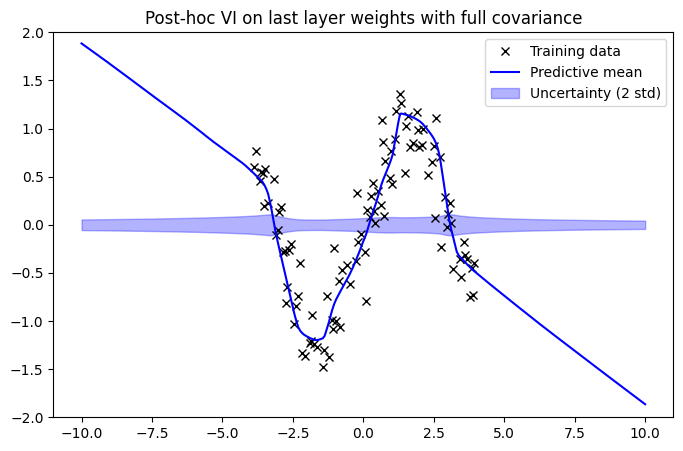

In [38]:
plt.figure(figsize=(8,5))
plt.ylim(-2,2)
plt.plot(xs_train.numpy(), ys_train.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), pred_mean, 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 mean_pred - 2 * std_pred,
                mean_pred + 2 * std_pred,
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with full covariance")
plt.show()


In [39]:
last_layer_vi.eval()
with torch.no_grad():
    X_test = torch.linspace(-10,10, 300).unsqueeze(1)
    features_test = lli_net.get_ll_embedd(X_test)
    preds_samples = []
    preds_stds = []
    for _ in range(100):
        preds = last_layer_vi.forward_sample(features_test)
        preds_samples.append(preds.squeeze())
    preds_samples = torch.stack(preds_samples)
    mean_pred = preds_samples.mean(dim=0)
    std_pred = preds_samples.std(dim=0)

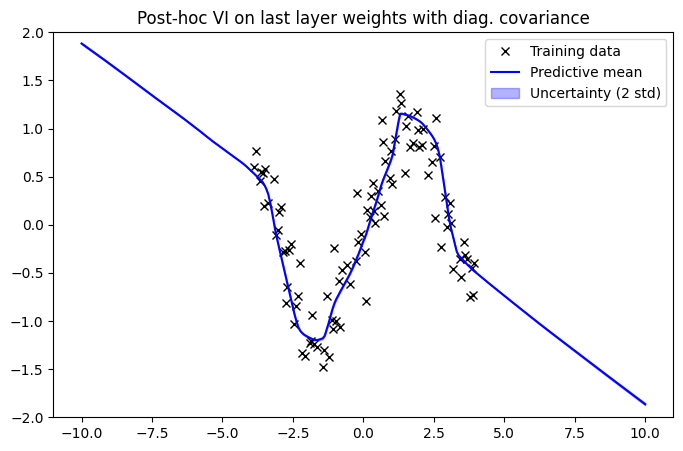

In [40]:
plt.figure(figsize=(8,5))
plt.ylim(-2,2)
plt.plot(xs_train.numpy(), ys_train.numpy(), 'kx', label='Training data')
plt.plot(X_test.numpy(), mean_pred.numpy(), 'b', label='Predictive mean')
plt.fill_between(X_test.squeeze().numpy(),
                 mean_pred.numpy() - 2 * std_pred.numpy(),
                mean_pred.numpy() + 2 * std_pred.numpy(),
                 color='blue', alpha=0.3, label='Uncertainty (2 std)')
plt.legend()
plt.title("Post-hoc VI on last layer weights with diag. covariance")
plt.show()
